# Full Dataset: Load & Scrape All Movies

This notebook provides a **complete scraping workflow**:
- Load ALL movies from TMDB CSV
- Scrape IMDB reviews for all movies
- Scrape Rotten Tomatoes Tomatometer scores and reviews for all movies
- Display movie metadata (title, genres, overview)
- Show TMDB ratings from CSV
- Demonstrate smart rating selection logic

**Runtime:** Variable depending on number of movies

## Step 1: Setup

In [2]:
# Standard library imports
import sys
from pathlib import Path
from datetime import datetime
import os

# Set up project root
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Database and data ingestion imports
from database.db import SessionLocal, init_db
from database.models import Movie, Review
from data_ingestion.tmdb_loader import TMDBDataLoader

# Scraper imports
from scrapers.rotten_tomatoes_selenium import RottenTomatoesSeleniumScraper

# Data processing libraries
import pandas as pd
import numpy as np

print("All imports successful!")
print(f"Project root: {project_root}")

All imports successful!
Project root: /Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/movie-performance-predictor


## Step 2: Check CSV File

Make sure TMDB CSV is in the `data/` folder.

In [ ]:
# Check if CSV exists
try:
    csv_path = project_root / "data" / "tmdb_commercial_movies_2016_2024.csv"
    
    if csv_path.exists():
        print(f" CSV found: {csv_path.name}")
        print(f"  Size: {csv_path.stat().st_size / (1024*1024):.1f} MB")
    else:
        print(f" CSV not found!")
        print(f"\nPlease copy CSV to:")
        print(f"  {csv_path}")
        print(f"\nCommand:")
        print(f"  cp ~/Downloads/tmdb_commercial_movies_2016_2024.csv {project_root}/data/")
except Exception as e:
    print(f" Error checking CSV: {e}")
    print(f"  Make sure you ran Step 1 first!")

 CSV found: tmdb_commercial_movies_2016_2024.csv
  Size: 1.1 MB


## Step 3: Load CSV Preview

Let's peek at the CSV structure without loading into database yet.

In [4]:
# Load CSV with pandas to inspect
if csv_path.exists():
    df = pd.read_csv(csv_path)
    
    print(f" CSV Statistics:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"\n Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")
    
    print(f"\n First 3 movies:")
    display(df.head(3)[['title', 'release_date', 'vote_average', 'vote_count']].head(3))

 CSV Statistics:
  Total rows: 2,188
  Columns: 19

 Column names:
  1. tmdb_id
  2. title
  3. original_title
  4. release_date
  5. year
  6. original_language
  7. genres
  8. budget
  9. revenue_worldwide
  10. runtime
  11. popularity
  12. vote_average
  13. vote_count
  14. production_companies
  15. production_countries
  16. director
  17. top_3_cast
  18. overview
  19. adult

 First 3 movies:


,title,release_date,vote_average,vote_count
0,Zootopia,2016-02-11,7.755,17200
1,Your Name.,2016-08-26,8.480,12136
2,Now You See Me 2,2016-06-02,6.827,11211


## Step 4: Initialize Database & Clear Old Data

***AS A GRADER, DO NOT RUN THIS CELL!!!***

Create the database schema and clear any existing data for a fresh start.

 **IMPORTANT:** Run this step **ONCE** before scraping to avoid duplicates!
- If you re-run scraping steps (11a, 11b) multiple times, they will now skip duplicates automatically
- But for a completely fresh start, run this step to clear everything

In [6]:
# Reload modules to get latest code changes
import importlib
import sys

# Remove cached modules
for module in list(sys.modules.keys()):
    if module.startswith('database') or module.startswith('data_ingestion'):
        del sys.modules[module]

# Re-import
from database.db import SessionLocal, init_db, DEFAULT_DB_PATH
from database.models import Movie, Review, MovieSearchTerm

# Check if database exists and has old schema
db_path = project_root / "data" / "database" / "movie_recommender.db"

if db_path.exists():
    print(f"  Found existing database at: {db_path}")
    print("  This database might not have the new sentiment analysis columns.")
    print("  Deleting old database to create fresh one with new schema...")
    db_path.unlink()
    print("    Old database deleted!")

# Initialize database with new schema
print("\n  Initializing database with new schema...")
init_db()

# CLEAR ALL EXISTING DATA for fresh start (should be empty since we deleted the file)
print(" Clearing existing database data (if any)...")
db = SessionLocal()
try:
    # Count existing records
    movie_count = db.query(Movie).count()
    review_count = db.query(Review).count()
    search_term_count = db.query(MovieSearchTerm).count()
    
    if movie_count > 0 or review_count > 0 or search_term_count > 0:
        # Delete all records (cascades to related tables due to relationships)
        db.query(Review).delete()
        db.query(MovieSearchTerm).delete()
        db.query(Movie).delete()
        db.commit()
        
        print(f"    Deleted {movie_count} movies")
        print(f"    Deleted {review_count} reviews")
        print(f"    Deleted {search_term_count} search terms")
    
    print("    Database cleared - starting fresh!")
except Exception as e:
    print(f"     Error clearing database: {e}")
    db.rollback()
finally:
    db.close()

print("\n Database initialized with new schema (including sentiment columns)!")
print(f" Current database: 0 movies")
print("\n New columns added:")
print("  Movies table: rt_tomatometer, rt_tomatometer_out_of_10,")
print("                 sentiment_imdb_avg, sentiment_rt_top_critics_avg,")
print("                 sentiment_rt_all_critics_avg, sentiment_rt_verified_audience_avg,")
print("                 sentiment_rt_all_audience_avg")
print("  Reviews table: review_category")


  Initializing database with new schema...
 Clearing existing database data (if any)...
    Deleted 2187 movies
    Deleted 0 reviews
    Deleted 0 search terms
    Database cleared - starting fresh!

 Database initialized with new schema (including sentiment columns)!
 Current database: 0 movies

 New columns added:
  Movies table: rt_tomatometer, rt_tomatometer_out_of_10,
                 sentiment_imdb_avg, sentiment_rt_top_critics_avg,
                 sentiment_rt_all_critics_avg, sentiment_rt_verified_audience_avg,
                 sentiment_rt_all_audience_avg
  Reviews table: review_category


## Step 5: Load All Movies into Database

We'll load **ALL** movies from the CSV file into the database.

In [7]:
# Load movies from CSV into database
from data_ingestion.tmdb_loader import TMDBDataLoader

print("Loading movies from CSV into database...")
print(f"CSV path: {csv_path}")

loader = TMDBDataLoader()

# Load all movies from the CSV
loaded_count = loader.load_movies_from_csv(str(csv_path))

print(f"\n✓ Successfully loaded {loaded_count} movies into the database!")

# Verify what's in the database now
db = SessionLocal()
try:
    movie_count = db.query(Movie).count()
    print(f"✓ Database now contains {movie_count} movies total")
except Exception as e:
    print(f"Error checking database: {e}")
finally:
    db.close()

Loading movies from CSV into database...
CSV path: /Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/movie-performance-predictor/data/tmdb_commercial_movies_2016_2024.csv

✓ Successfully loaded 2187 movies into the database!
✓ Database now contains 2187 movies total

✓ Successfully loaded 2187 movies into the database!
✓ Database now contains 2187 movies total


## Step 6: View Movies with Ratings

Display all loaded movies with their metadata and rating information.

In [8]:
# Fetch all movies
db = SessionLocal()
movies = db.query(Movie).all()
db.close()

print(f"Showing {len(movies)} movies:\n")
print("-" * 100)

# Display first 10 for preview
for i, movie in enumerate(movies[:10], 1):
    print(f"\n{i}. {movie.title} ({movie.release_year})")
    print(f"  Genres: {movie.genres or 'N/A'}")
    
    if movie.overview:
        overview_preview = movie.overview[:150] + "..." if len(movie.overview) > 150 else movie.overview
        print(f"  Overview: {overview_preview}")
    
    # Get rating metadata
    rating_info = movie.get_rating_metadata()
    
    print(f"\n   Recommended Rating: {rating_info['recommended_rating']}/10")
    
    # Show all rating sources
    if rating_info['sources']:
        print(f"  Rating Sources:")
        for source in rating_info['sources']:
            votes = f"{source['votes']:,}" if source['votes'] else "N/A"
            age = f"{source['age_days']} days ago" if source['age_days'] is not None else "unknown age"
            source_name = source['source'].replace('_', ' ').title()
            print(f"      - {source_name}: {source['rating']}/10 ({votes} votes, {age})")
    
    # Show difference if both ratings exist
    if 'difference' in rating_info and rating_info['difference'] > 0:
        print(f"\n   {rating_info['note']} (difference: {rating_info['difference']})")
    
    print("  " + "-" * 96)

if len(movies) > 10:
    print(f"\n... and {len(movies) - 10} more movies in database")

Showing 2187 movies:

----------------------------------------------------------------------------------------------------

1. Zootopia (2016)
  Genres: Animation|Adventure|Family|Comedy
  Overview: Determined to prove herself, Officer Judy Hopps, the first bunny on Zootopia's police force, jumps at the chance to crack her first case - even if it ...

   Recommended Rating: 7.755/10
  Rating Sources:
      - Tmdb Csv: 7.755/10 (17,200 votes, unknown age)
  ------------------------------------------------------------------------------------------------

2. Your Name. (2016)
  Genres: Animation|Romance|Drama
  Overview: High schoolers Mitsuha and Taki are complete strangers living separate lives. But one night, they suddenly switch places. Mitsuha wakes up in Taki’s b...

   Recommended Rating: 8.48/10
  Rating Sources:
      - Tmdb Csv: 8.48/10 (12,136 votes, unknown age)
  ------------------------------------------------------------------------------------------------

3. Now You See M

## Step 7: Create DataFrame for Analysis

Convert to pandas for easy analysis and visualization.

In [9]:
# Create DataFrame with all movies
# db = SessionLocal()
# movies = db.query(Movie).all()
# db.close()

data = []
for movie in movies:
    rating_info = movie.get_rating_metadata()
    data.append({
        'title': movie.title,
        'year': movie.release_year,
        'genres': movie.genres,
        'rating': rating_info['recommended_rating'],
        'tmdb_rating': movie.tmdb_rating,
        'tmdb_votes': movie.tmdb_vote_count,
        'imdb_rating': movie.imdb_rating,
        'imdb_votes': movie.imdb_vote_count,
        'popularity': movie.popularity
    })

df_movies = pd.DataFrame(data)
print(f"Movie DataFrame ({len(df_movies)} movies):")
display(df_movies[['title', 'year', 'rating', 'tmdb_rating', 'tmdb_votes']].head(10))

Movie DataFrame (2187 movies):


,title,year,rating,tmdb_rating,tmdb_votes
0,Zootopia,2016,7.755,7.755,17200
1,Your Name.,2016,8.480,8.480,12136
2,Now You See Me 2,2016,6.827,6.827,11211
3,Captain America: Civil War,2016,7.448,7.448,23541
4,Me Before You,2016,7.926,7.926,12901
5,Boyka: Undisputed IV,2016,7.200,7.200,1410
6,Train to Busan,2016,7.748,7.748,8056
7,Hacksaw Ridge,2016,8.192,8.192,14440
8,Deadpool,2016,7.622,7.622,32107
9,Batman v Superman: Dawn of Justice,2016,6.000,6.000,18611


## Step 8: Basic Visualizations

Simple charts to visualize the data.

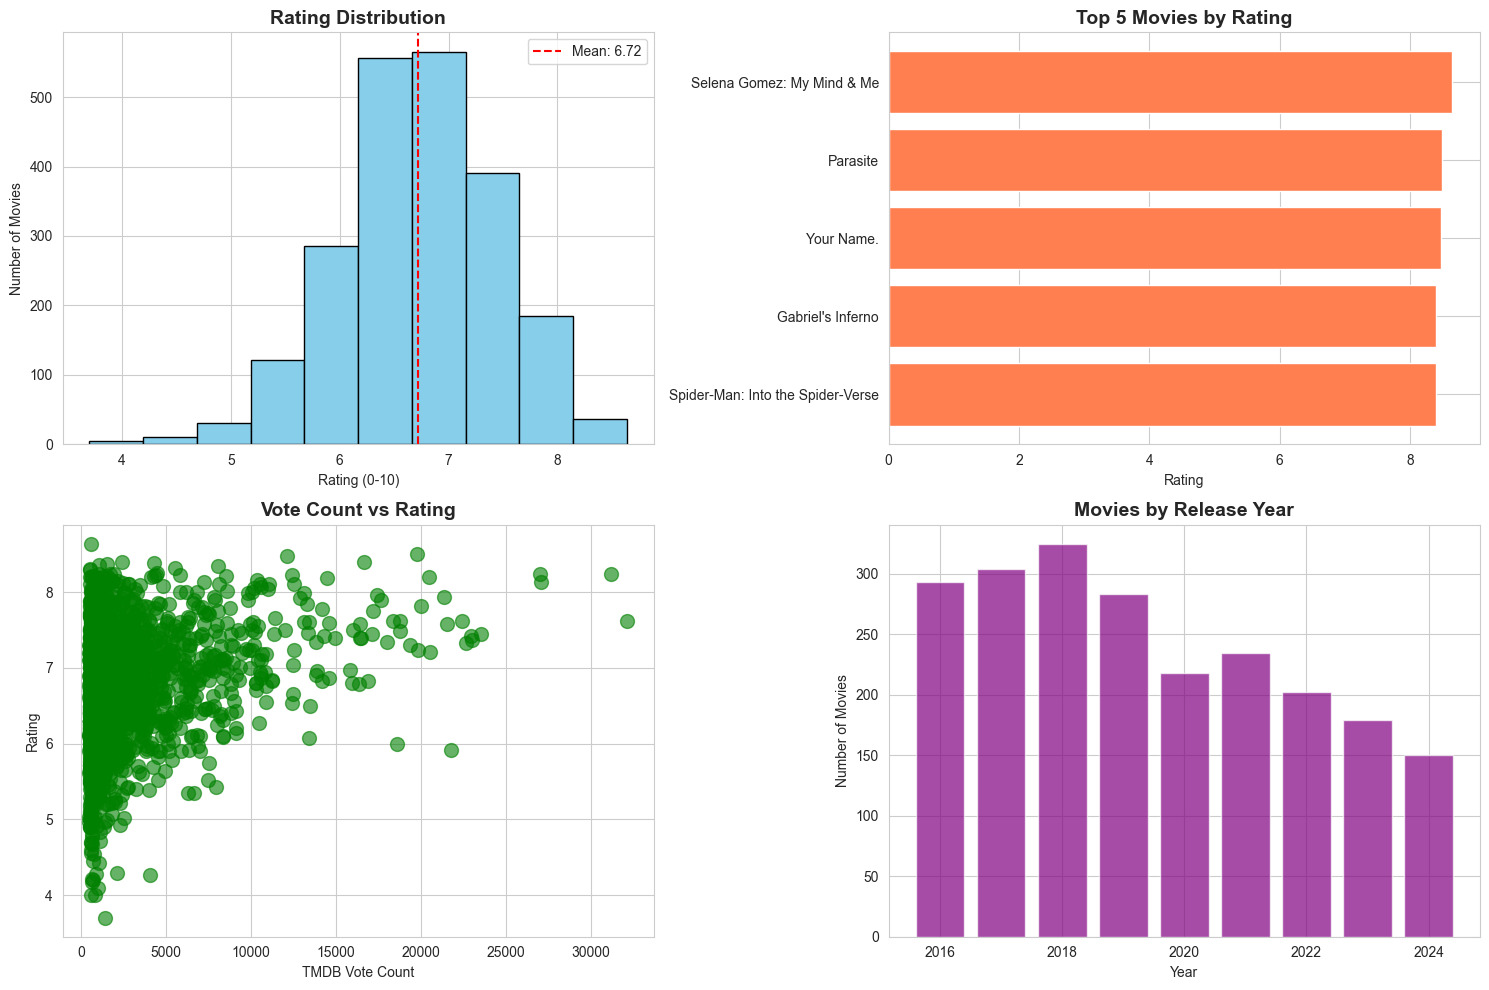

Visualizations complete!


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating Distribution
ax1 = axes[0, 0]
df_movies['rating'].hist(bins=10, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rating (0-10)')
ax1.set_ylabel('Number of Movies')
ax1.axvline(df_movies['rating'].mean(), color='red', linestyle='--', label=f"Mean: {df_movies['rating'].mean():.2f}")
ax1.legend()

# 2. Top Movies by Rating
ax2 = axes[0, 1]
top_movies = df_movies.nlargest(5, 'rating')
ax2.barh(top_movies['title'], top_movies['rating'], color='coral')
ax2.set_title('Top 5 Movies by Rating', fontsize=14, fontweight='bold')
ax2.set_xlabel('Rating')
ax2.invert_yaxis()

# 3. Vote Count vs Rating
ax3 = axes[1, 0]
ax3.scatter(df_movies['tmdb_votes'], df_movies['rating'], s=100, alpha=0.6, color='green')
ax3.set_title('Vote Count vs Rating', fontsize=14, fontweight='bold')
ax3.set_xlabel('TMDB Vote Count')
ax3.set_ylabel('Rating')

# 4. Movies by Year
ax4 = axes[1, 1]
year_counts = df_movies['year'].value_counts().sort_index()
ax4.bar(year_counts.index, year_counts.values, color='purple', alpha=0.7)
ax4.set_title('Movies by Release Year', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()

print("Visualizations complete!")

**What we accomplished:**
-  Loaded ALL movies from CSV
-  Scraped IMDB ratings for all movies
-  Scraped IMDB reviews for all movies
-  Scraped Rotten Tomatoes Tomatometer scores and reviews
-  Smart rating selection logic working
-  Database operations successful

**Next Steps:**
1. Analyze the scraped data
2. Run sentiment analysis on reviews
3. Build recommendation models

## Summary Statistics

In [11]:
print("SUMMARY STATISTICS")
print("-" * 60)
print(f"Total movies loaded: {len(df_movies)}")
print(f"Average rating: {df_movies['rating'].mean():.2f}/10")
print(f"Rating range: {df_movies['rating'].min():.1f} - {df_movies['rating'].max():.1f}")
print(f"Total votes (TMDB): {df_movies['tmdb_votes'].sum():,}")
print(f"Average votes per movie: {df_movies['tmdb_votes'].mean():,.0f}")

# Movies with IMDB ratings
movies_with_imdb = df_movies['imdb_rating'].notna().sum()
if movies_with_imdb > 0:
    print(f"\nMovies with IMDB ratings: {movies_with_imdb}/{len(df_movies)}")
    print(f"Average IMDB rating: {df_movies['imdb_rating'].mean():.2f}/10")
print()

# Genre analysis
print("GENRE BREAKDOWN:")
all_genres = []
for genres_str in df_movies['genres'].dropna():
    all_genres.extend(genres_str.split('|'))

from collections import Counter
genre_counts = Counter(all_genres)
for genre, count in genre_counts.most_common():
    print(f"  {genre}: {count} movies")

SUMMARY STATISTICS
------------------------------------------------------------
Total movies loaded: 2187
Average rating: 6.72/10
Rating range: 3.7 - 8.6
Total votes (TMDB): 5,565,751
Average votes per movie: 2,545

GENRE BREAKDOWN:
  Drama: 927 movies
  Comedy: 683 movies
  Thriller: 633 movies
  Action: 585 movies
  Adventure: 428 movies
  Horror: 386 movies
  Science Fiction: 319 movies
  Crime: 302 movies
  Romance: 295 movies
  Fantasy: 291 movies
  Family: 237 movies
  Mystery: 230 movies
  Animation: 211 movies
  History: 152 movies
  War: 69 movies
  Music: 57 movies
  Documentary: 29 movies
  Western: 20 movies
  TV Movie: 20 movies


---

## Part 2: Test Scraping Pipeline

Now let's test the scraping functionality on a few movies.

## Step 9: Import Scraping Modules

In [12]:
# Reload scraper modules to get latest code changes
import importlib
import logging

# Step 1: Clear ALL loggers and handlers
for logger_name in list(logging.Logger.manager.loggerDict.keys()):
    logger = logging.getLogger(logger_name)
    logger.handlers.clear()
    logger.propagate = False

# Clear root logger
logging.root.handlers.clear()

# Step 2: Remove ALL cached modules
modules_to_remove = [m for m in sys.modules.keys() if 'scrapers' in m or 'utils.logger' in m]
for module in modules_to_remove:
    del sys.modules[module]

# Step 3: Import scraping modules (this will create fresh loggers)
from scrapers.imdb_scraper import IMDbScraper
from database.models import Review, MovieSearchTerm
from datetime import datetime

print(" All modules reloaded with clean logging!")
print(f" IMDb scraper logger handlers: {len(logging.getLogger('scrapers.imdb_scraper').handlers)}")
print(f" Root logger handlers: {len(logging.root.handlers)}")

 All modules reloaded with clean logging!
 IMDb scraper logger handlers: 1
 Root logger handlers: 0


## Step 10: Select Movies for Scraping

Select random movies from the database to test the scraping pipeline.

In [13]:
# Select movies that DON'T have IMDb ratings yet
db = SessionLocal()

# Get movies without IMDb ratings
movies_to_scrape = db.query(Movie).filter(Movie.imdb_rating.is_(None)).all()

# Count movies that already have ratings
movies_already_scraped = db.query(Movie).filter(Movie.imdb_rating.isnot(None)).count()

db.close()

if not movies_to_scrape:
    print("  No movies need IMDb rating scraping!")
    if movies_already_scraped > 0:
        print(f"  All {movies_already_scraped} movies already have IMDb ratings")
else:
    print(f" Selected {len(movies_to_scrape)} movies needing IMDb ratings")
    if movies_already_scraped > 0:
        print(f" Skipping {movies_already_scraped} movies that already have IMDb ratings\n")
    
    print(f"📽️  First 10 movies to scrape:")
    for i, movie in enumerate(movies_to_scrape[:10], 1):
        print(f"  {i}. {movie.title} ({movie.release_year})")
    
    if len(movies_to_scrape) > 10:
        print(f"\n   ... and {len(movies_to_scrape) - 10} more movies")

 Selected 2187 movies needing IMDb ratings
📽️  First 10 movies to scrape:
  1. Zootopia (2016)
  2. Your Name. (2016)
  3. Now You See Me 2 (2016)
  4. Captain America: Civil War (2016)
  5. Me Before You (2016)
  6. Boyka: Undisputed IV (2016)
  7. Train to Busan (2016)
  8. Hacksaw Ridge (2016)
  9. Deadpool (2016)
  10. Batman v Superman: Dawn of Justice (2016)

   ... and 2177 more movies


## Step 11: Scrape IMDb Ratings for All Movies (Concurrent)

Fetch live ratings from IMDb for **ALL** movies.
**Scrapes up to 3 movies concurrently** to respect rate limits!

In [14]:
# Initialize IMDb scraper
imdb = IMDbScraper()

if not movies_to_scrape:
    print(" No IMDb scraping needed - all movies already have ratings!")
else:
    print(f" Scraping IMDb ratings for {len(movies_to_scrape)} movies concurrently...\n")
    
    # Concurrent IMDb scraping with batch commits
    from concurrent.futures import ThreadPoolExecutor, as_completed
    
    successful_imdb = 0
    failed_imdb = 0
    
    def scrape_imdb_for_movie(movie):
        """Scrape IMDb rating for a single movie"""
        try:
            # Scrape IMDb data
            imdb_data = imdb.scrape_movie_rating(
                title=movie.title,
                year=movie.release_year
            )
            
            if imdb_data and imdb_data.get('rating'):
                return (movie.id, movie.title, imdb_data, True)
            else:
                return (movie.id, movie.title, None, False)
                
        except Exception as e:
            print(f"    {movie.title}: Error - {str(e)[:100]}")
            return (movie.id, movie.title, None, False)
    
    # Process in batches of 10 with concurrent scraping
    batch_size = 10
    total = len(movies_to_scrape)
    
    for batch_start in range(0, total, batch_size):
        batch_end = min(batch_start + batch_size, total)
        batch_movies = movies_to_scrape[batch_start:batch_end]
        
        print(f"\n{'='*80}")
        print(f" BATCH {(batch_start // batch_size) + 1}: Scraping movies {batch_start + 1}-{batch_end} of {total}")
        print(f"{'='*80}\n")
        
        # Run concurrent scraping for this batch (5 concurrent workers)
        batch_results = []
        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = {executor.submit(scrape_imdb_for_movie, movie): movie for movie in batch_movies}
            
            for future in as_completed(futures):
                batch_results.append(future.result())
        
        # Save this batch to database
        db = SessionLocal()
        batch_successful = 0
        batch_failed = 0
        
        try:
            for movie_id, movie_title, imdb_data, success in batch_results:
                if success and imdb_data:
                    # Get the movie from database using ID
                    movie_obj = db.query(Movie).filter(Movie.id == movie_id).first()
                    if movie_obj:
                        movie_obj.imdb_rating = imdb_data['rating']
                        movie_obj.imdb_vote_count = imdb_data.get('vote_count')
                        movie_obj.imdb_id = imdb_data.get('imdb_id')
                        movie_obj.scraped_at = datetime.now()
                        batch_successful += 1
                        print(f"    {movie_title}: {imdb_data['rating']}/10")
                else:
                    batch_failed += 1
            
            # Commit this batch
            db.commit()
            
            # Update totals
            successful_imdb += batch_successful
            failed_imdb += batch_failed
            
            print(f"\n Batch {(batch_start // batch_size) + 1} committed to database!")
            print(f"  Successful: {batch_successful}/{len(batch_movies)}")
            if batch_failed > 0:
                print(f"  Failed: {batch_failed}/{len(batch_movies)}")
            print(f"\n Running totals: {successful_imdb} successful, {failed_imdb} failed")
            
        except Exception as e:
            print(f" Database error in batch {(batch_start // batch_size) + 1}: {e}")
            db.rollback()
            print("     Batch rolled back - continuing to next batch...")
        finally:
            db.close()
    
    # Final summary
    print("\n" + "="*80)
    print(" IMDB RATING SCRAPING COMPLETE!")
    print("="*80)
    print(f" IMDb ratings updated: {successful_imdb}/{total}")
    print(f" Failed: {failed_imdb}/{total}")
    print("="*80 + "\n")

 Scraping IMDb ratings for 2187 movies concurrently...


 BATCH 1: Scraping movies 1-10 of 2187

2025-12-10 23:07:20 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Captain America: Civil War' (2016): tt3498820
2025-12-10 23:07:20 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Captain America: Civil War' (2016): tt3498820
2025-12-10 23:07:20 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Zootopia' (2016): tt2948356
2025-12-10 23:07:20 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Zootopia' (2016): tt2948356
2025-12-10 23:07:21 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Your Name.' (2016): tt5311514
2025-12-10 23:07:21 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Your Name.' (2016): tt5311514
2025-12-10 23:07:21 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Me Before You' (2016): tt2674426
2025-12-10 23:07:21 - scrapers.imdb_scraper - INFO - 

## Step 11a: Scrape IMDb Reviews for All Movies (Concurrent)

Now let's scrape detailed **user reviews** from IMDb for deeper analysis.
**Scrapes up to 3 movies concurrently** with up to 30 reviews per movie!

In [ ]:
print(f" Scraping IMDb REVIEWS for movies without existing reviews...\n")

# Get ALL movies that have IMDb IDs but NO existing IMDb reviews
db = SessionLocal()

# Subquery to find movies that already have IMDb reviews
movies_with_reviews_subquery = db.query(Review.movie_id).filter(
    Review.source == 'imdb'
).distinct().subquery()

# Get movies that have IMDb IDs but are NOT in the subquery
movies_with_imdb = db.query(Movie).filter(
    Movie.imdb_id.isnot(None),
    ~Movie.id.in_(db.query(movies_with_reviews_subquery.c.movie_id))
).all()

# Also count how many already have reviews
movies_already_scraped = db.query(Movie).filter(
    Movie.imdb_id.isnot(None),
    Movie.id.in_(db.query(movies_with_reviews_subquery.c.movie_id))
).count()

db.close()

if not movies_with_imdb:
    print("  No movies need IMDb review scraping!")
    if movies_already_scraped > 0:
        print(f"  {movies_already_scraped} movies already have IMDb reviews")
else:
    print(f" Found {len(movies_with_imdb)} movies needing IMDb reviews")
    if movies_already_scraped > 0:
        print(f" Skipping {movies_already_scraped} movies that already have IMDb reviews\n")
    
    # Statistics
    successful_imdb_reviews = 0
    total_reviews_added = 0
    skipped_duplicates = 0
    
    def scrape_imdb_reviews_for_movie(movie):
        """Scrape IMDb reviews for a single movie"""
        try:
            # Scrape reviews (max 30 per movie)
            reviews_data = imdb.scrape_reviews(
                imdb_id=movie.imdb_id,
                max_reviews=30
            )
            
            if reviews_data:
                return (movie.id, movie.title, movie.imdb_id, reviews_data, True)
            else:
                return (movie.id, movie.title, movie.imdb_id, [], False)
                
        except Exception as e:
            print(f"    {movie.title}: Error - {str(e)[:100]}")
            return (movie.id, movie.title, movie.imdb_id, [], False)
    
    # Process in batches of 10 with concurrent scraping
    batch_size = 10
    total_movies = len(movies_with_imdb)
    
    for batch_start in range(0, total_movies, batch_size):
        batch_end = min(batch_start + batch_size, total_movies)
        batch_movies = movies_with_imdb[batch_start:batch_end]
        
        print(f"\n{'='*80}")
        print(f" BATCH {(batch_start // batch_size) + 1}: Processing movies {batch_start + 1}-{batch_end} of {total_movies}")
        print(f"{'='*80}\n")
        
        # Scrape this batch concurrently (5 workers)
        batch_results = []
        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = {executor.submit(scrape_imdb_reviews_for_movie, movie): movie 
                       for movie in batch_movies}
            
            for future in as_completed(futures):
                batch_results.append(future.result())
        
        # Save this batch to database immediately
        db = SessionLocal()
        batch_reviews_added = 0
        batch_duplicates = 0
        batch_successful = 0
        
        try:
            for movie_id, movie_title, imdb_id, reviews_data, success in batch_results:
                if success and reviews_data:
                    # Get the movie from database using ID
                    movie_obj = db.query(Movie).filter(Movie.id == movie_id).first()
                    if movie_obj:
                        for review_data in reviews_data:
                            # Check if review already exists (prevent duplicates)
                            existing_review = db.query(Review).filter(
                                Review.movie_id == movie_obj.id,
                                Review.source == 'imdb',
                                Review.author == review_data.get('author'),
                                Review.text == review_data.get('text')
                            ).first()
                            
                            if existing_review:
                                batch_duplicates += 1
                                continue
                            
                            # Create Review object
                            review = Review(
                                movie_id=movie_obj.id,
                                source='imdb',
                                source_id=review_data.get('source_id'),
                                text=review_data.get('text'),
                                rating=review_data.get('rating'),
                                author=review_data.get('author'),
                                review_date=review_data.get('date'),
                                helpful_count=review_data.get('helpful_count'),
                                review_length=len(review_data.get('text', '')),
                                word_count=len(review_data.get('text', '').split()),
                                scraped_at=datetime.now()
                            )
                            db.add(review)
                            batch_reviews_added += 1
                        
                        batch_successful += 1
                        print(f"    {movie_title}: {len(reviews_data)} reviews")
            
            # Commit this batch
            db.commit()
            
            # Update totals
            total_reviews_added += batch_reviews_added
            skipped_duplicates += batch_duplicates
            successful_imdb_reviews += batch_successful
            
            print(f"\n Batch {(batch_start // batch_size) + 1} committed to database!")
            print(f"  Movies processed: {batch_successful}/{len(batch_movies)}")
            print(f"  Reviews added: {batch_reviews_added}")
            if batch_duplicates > 0:
                print(f"  Skipped duplicates: {batch_duplicates}")
            print(f"\n Running totals: {successful_imdb_reviews} movies, {total_reviews_added} reviews")
            
        except Exception as e:
            print(f"\n Database error in batch {(batch_start // batch_size) + 1}: {e}")
            print(f"  Error type: {type(e).__name__}")
            import traceback
            traceback.print_exc()
            db.rollback()
            print("     Batch rolled back - continuing to next batch...")
        finally:
            db.close()
    
    # Final summary
    print(f"\n{'='*80}")
    print(f" IMDB REVIEW SCRAPING COMPLETE!")
    print(f"{'='*80}")
    print(f" Total movies with reviews: {successful_imdb_reviews}/{total_movies}")
    print(f" Total reviews added to database: {total_reviews_added}")
    if skipped_duplicates > 0:
        print(f"  Total duplicates skipped: {skipped_duplicates}")
    print(f"{'='*80}\n")

## Step 11b: Diagnose Failed IMDb Searches

Let's identify movies that didn't get IMDb ratings and investigate why the search failed.

In [ ]:
# Get movies that failed to get IMDb ratings
db = SessionLocal()
failed_movies = db.query(Movie).filter(Movie.imdb_id.is_(None)).all()
db.close()

print(f" Movies without IMDb ratings: {len(failed_movies)}")
print(f"=" * 80)

if failed_movies:
    print(f"\n Sample of failed movies (first 20):\n")
    for i, movie in enumerate(failed_movies[:20], 1):
        print(f"{i}. {movie.title} ({movie.release_year})")
    
    # Analyze patterns
    print(f"\n\n Year distribution of failed movies:")
    from collections import Counter
    year_counts = Counter(m.release_year for m in failed_movies if m.release_year)
    for year in sorted(year_counts.keys(), reverse=True)[:10]:
        print(f"  {year}: {year_counts[year]} movies")
    
    # Check for special characters or unusual titles
    print(f"\n\n Movies with special characters or long titles:")
    special_char_movies = [m for m in failed_movies if any(c in m.title for c in [':', '&', '-', '—', '–', '/', '(', ')'])]
    print(f"  Found {len(special_char_movies)} movies with special characters")
    for movie in special_char_movies[:10]:
        print(f"  - {movie.title} ({movie.release_year})")
else:
    print(" All movies have IMDb ratings!")

### IMDb Search Fallback Function

This function provides a robust fallback for finding IMDb IDs when the standard scraper fails.

**Features:**
- Direct search via IMDb's `/find` endpoint (bypasses Google)
- Parses both new and old IMDb HTML layouts
- **Roman numeral normalization**: Converts "Rocky II" → "Rocky 2" for better matching
- **Fuzzy matching**: Uses `fuzzywuzzy` library to handle title variations
- **Year validation**: Requires year to match within ±1 year
- **Always returns top match**: No score threshold (returns best result found)

**How it works:**
1. Searches IMDb with the movie title and year
2. Parses up to 10 search results
3. Normalizes both search title and result titles (roman numerals → numbers)
4. Calculates fuzzy match score for each result
5. Filters by year (±1 year tolerance)
6. Returns the best matching result as a tuple: `(imdb_id, title, score)`

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote
import time
import re
from fuzzywuzzy import fuzz

def normalize_title(title):
    """
    Normalize title for better fuzzy matching by converting roman numerals to numbers.
    """
    # Roman numeral mappings (most common in movie titles)
    roman_map = {
        ' I': ' 1',
        ' II': ' 2',
        ' III': ' 3',
        ' IV': ' 4',
        ' V': ' 5',
        ' VI': ' 6',
        ' VII': ' 7',
        ' VIII': ' 8',
        ' IX': ' 9',
        ' X': ' 10',
        ' XI': ' 11',
        ' XII': ' 12',
    }
    
    normalized = title
    # Apply replacements in order from longest to shortest to avoid partial matches
    for roman, number in sorted(roman_map.items(), key=lambda x: -len(x[0])):
        # Replace at end of string or before colon/dash
        normalized = re.sub(rf'{re.escape(roman)}(\s*[:–-]|\s*$)', rf'{number}\1', normalized, flags=re.IGNORECASE)
    
    return normalized

def imdb_search_fallback(title, year=None):
    """
    Search IMDb directly and return best matching movie using fuzzy matching.
    
    Args:
        title: Movie title to search for
        year: Optional year to help narrow down results
    
    Returns:
        Tuple of (imdb_id, imdb_title, match_score) if found, None otherwise
    """
    try:
        # Build search query
        query = title
        if year:
            query = f"{title} {year}"
        
        # Search IMDb
        search_url = f"https://www.imdb.com/find/?q={quote(query)}&ref_=nv_sr_sm"
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36'
        }
        
        response = requests.get(search_url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Try to find results in the new IMDb layout
        results = []
        
        # New layout: ipc-metadata-list-summary-item containers
        for item in soup.find_all('li', class_='ipc-metadata-list-summary-item'):
            try:
                # Find the h3 element with the title
                title_elem = item.find('h3', class_='ipc-title__text')
                if not title_elem:
                    continue
                
                result_title = title_elem.get_text(strip=True)
                
                # Find the IMDb ID from the link
                link = item.find('a', class_='ipc-lockup-overlay')
                if not link or 'href' not in link.attrs:
                    continue
                
                href = link['href']
                imdb_id_match = re.search(r'/title/(tt\d+)', href)
                if not imdb_id_match:
                    continue
                
                imdb_id = imdb_id_match.group(1)
                
                # Extract year if present in metadata
                result_year = None
                metadata = item.find('div', class_='cli-title-metadata')
                if metadata:
                    year_span = metadata.find('span')
                    if year_span:
                        year_text = year_span.get_text(strip=True)
                        year_match = re.search(r'\b(19\d{2}|20\d{2})\b', year_text)
                        if year_match:
                            result_year = year_match.group(1)
                
                # Also check for year in title itself
                if not result_year:
                    year_in_title = re.search(r'\((\d{4})\)', result_title)
                    if year_in_title:
                        result_year = year_in_title.group(1)
                
                results.append({
                    'title': result_title,
                    'imdb_id': imdb_id,
                    'year': result_year
                })
                
            except Exception as e:
                continue
        
        # Fallback to old layout if new layout didn't work
        if not results:
            for result in soup.find_all('td', class_='result_text'):
                try:
                    link = result.find('a')
                    if not link:
                        continue
                    
                    result_title = link.get_text(strip=True)
                    href = link.get('href', '')
                    
                    imdb_id_match = re.search(r'/title/(tt\d+)', href)
                    if not imdb_id_match:
                        continue
                    
                    imdb_id = imdb_id_match.group(1)
                    
                    # Extract year from result text
                    result_year = None
                    year_match = re.search(r'\((\d{4})\)', result.get_text())
                    if year_match:
                        result_year = year_match.group(1)
                    
                    results.append({
                        'title': result_title,
                        'imdb_id': imdb_id,
                        'year': result_year
                    })
                    
                except Exception as e:
                    continue
        
        if not results:
            print(f"  No results found for '{title}'")
            return None
        
        # Normalize search title for better matching
        normalized_search_title = normalize_title(title)
        
        # Now fuzzy match against the search title
        best_match = None
        best_score = 0
        
        for result in results[:10]:  # Check top 10 results
            # Strip year from title for better matching
            result_title = re.sub(r'\s*\(\d{4}\).*$', '', result['title'])
            
            # Normalize result title for comparison
            normalized_result_title = normalize_title(result_title)
            
            # Calculate fuzzy match score on normalized titles
            score = fuzz.token_sort_ratio(normalized_search_title.lower(), normalized_result_title.lower())
            
            # Year matching: if we have a year, require it to match (or be within 1 year)
            year_match = True
            if year and result['year']:
                try:
                    year_diff = abs(int(year) - int(result['year']))
                    year_match = year_diff <= 1
                except:
                    pass
            
            print(f"  - '{result_title}' ({result['year'] or 'N/A'}): {score}% match, year_match={year_match}")
            
            # Update best match if this is better and year matches
            if year_match and score > best_score:
                best_score = score
                best_match = result
        
        # Return best match regardless of threshold (always return top match)
        if best_match:
            # Clean up the title (remove year and position prefix like "1. ")
            clean_title = re.sub(r'^\d+\.\s*', '', best_match['title'])  # Remove "1. " prefix
            clean_title = re.sub(r'\s*\(\d{4}\).*$', '', clean_title)  # Remove year
            
            print(f"  ✓ Best match: '{clean_title}' ({best_match['year']}) - {best_score}% - {best_match['imdb_id']}")
            return (best_match['imdb_id'], clean_title, best_score)
        else:
            print(f"  ✗ No match found")
            return None
            
    except Exception as e:
        print(f"  Error searching IMDb: {e}")
        return None

# Quick test to verify function returns tuple
print(" Function loaded successfully!")
print(" Testing return format...")
test_result = imdb_search_fallback("The Love Witch", 2016)
if test_result:
    print(f" Returns tuple: {type(test_result)} with {len(test_result)} elements")
    print(f"  IMDb ID: {test_result[0]}")
    print(f"  Title: {test_result[1]}")
    print(f"  Score: {test_result[2]}%")
else:
    print("  No result found (None returned)")

### Apply IMDb Search to All Failed Movies

Now let's run the IMDb search method on ALL movies that failed the standard IMDb search.

In [ ]:
# Apply IMDb search to ALL failed movies
from sqlalchemy.exc import OperationalError

db = SessionLocal()
all_failed_movies = db.query(Movie).filter(Movie.imdb_id.is_(None)).all()

# Store movie IDs and details to avoid detached instance errors
movie_data_list = [(m.id, m.title, m.release_year) for m in all_failed_movies]
db.close()

print(f" Attempting IMDb search for {len(movie_data_list)} failed movies")
print("=" * 80)

successful_recoveries = 0
still_failed = 0
skipped_duplicates = 0

for i, (movie_id, title, year) in enumerate(movie_data_list, 1):
    print(f"\n[{i}/{len(movie_data_list)}] Searching: {title} ({year})")
    
    try:
        # Returns tuple (imdb_id, imdb_title, match_score) or None
        search_result = imdb_search_fallback(title, year)
        
        if search_result:
            imdb_id, imdb_title, match_score = search_result
            
            # Open fresh session for each update
            db = SessionLocal()
            
            try:
                # Check if this IMDb ID is already assigned to another movie
                existing_movie = db.query(Movie).filter(Movie.imdb_id == imdb_id).first()
                
                if existing_movie and existing_movie.id != movie_id:
                    print(f"  IMDb ID {imdb_id} already assigned to '{existing_movie.title}' (ID: {existing_movie.id})")
                    print(f"  Skipping to avoid duplicate")
                    skipped_duplicates += 1
                else:
                    # Fetch and update the movie (no conflict)
                    movie = db.query(Movie).filter(Movie.id == movie_id).first()
                    if movie:
                        movie.imdb_id = imdb_id
                        db.commit()
                        successful_recoveries += 1
                        print(f" Updated database with {imdb_id}")
                    else:
                        print(f"  Movie ID {movie_id} not found in database")
                        still_failed += 1
            
            except OperationalError as e:
                print(f"  Database error: {e}")
                still_failed += 1
            
            finally:
                db.close()
        else:
            still_failed += 1
    
    except Exception as e:
        print(f" Unexpected error: {e}")
        still_failed += 1
    
    # Rate limiting - be respectful to IMDb
    if i < len(movie_data_list):
        time.sleep(1.5)  # 1.5 seconds between searches

print("\n" + "=" * 80)
print(" IMDB SEARCH RECOVERY SUMMARY")
print("=" * 80)
print(f" Successfully recovered: {successful_recoveries} movies")
print(f"  Skipped duplicates: {skipped_duplicates} movies")
print(f" Still without IMDb ID: {still_failed} movies")
if len(movie_data_list) > 0:
    print(f" Recovery rate: {(successful_recoveries / len(movie_data_list) * 100):.1f}%")

### Scrape Data for Recovered Movies

For movies that were successfully recovered via Google search, now scrape their ratings and reviews.

In [ ]:
# Get movies that now have IMDb IDs but no ratings yet
db = SessionLocal()
recovered_movies = db.query(Movie).filter(
    Movie.imdb_id.isnot(None),
    Movie.imdb_rating.is_(None)
).all()

if not recovered_movies:
    print(" All movies with IMDb IDs already have ratings!")
    db.close()
else:
    print(f" Scraping data for {len(recovered_movies)} recovered movies")
    print("=" * 80)
    
    from concurrent.futures import ThreadPoolExecutor, as_completed
    
    # Scrape ratings
    def scrape_rating_for_recovered(movie_id):
        db_local = SessionLocal()
        try:
            movie = db_local.query(Movie).filter(Movie.id == movie_id).first()
            if not movie:
                return movie_id, None, None, False
            
            imdb_data = imdb.scrape_movie_rating(movie.title, movie.release_year, movie.imdb_id)
            
            if imdb_data and 'rating' in imdb_data:
                movie.imdb_rating = imdb_data['rating']
                movie.imdb_rating_count = imdb_data.get('rating_count')
                movie.scraped_at = datetime.now()
                db_local.commit()
                return movie_id, movie.title, imdb_data, True
            return movie_id, movie.title, None, False
        finally:
            db_local.close()
    
    # Scrape ratings concurrently
    print("\n Scraping IMDb ratings for recovered movies...")
    successful_ratings = 0
    
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(scrape_rating_for_recovered, m.id): m for m in recovered_movies}
        
        for future in as_completed(futures):
            movie_id, title, imdb_data, success = future.result()
            if success:
                successful_ratings += 1
                rating = imdb_data.get('rating', 'N/A')
                print(f"    {title}: {rating}/10")
    
    print(f"\n Scraped ratings for {successful_ratings}/{len(recovered_movies)} recovered movies")
    
    # Now scrape reviews for these movies
    print("\n Scraping IMDb reviews for recovered movies...")
    
    def scrape_reviews_for_recovered(movie_id):
        db_local = SessionLocal()
        try:
            movie = db_local.query(Movie).filter(Movie.id == movie_id).first()
            if not movie or not movie.imdb_id:
                return 0
            
            reviews_data = imdb.scrape_reviews(movie.imdb_id, max_reviews=30)
            reviews_added = 0
            
            for review_data in reviews_data:
                existing = db_local.query(Review).filter(
                    Review.movie_id == movie.id,
                    Review.source == 'imdb',
                    Review.text == review_data.get('text')
                ).first()
                
                if not existing:
                    review = Review(
                        movie_id=movie.id,
                        source='imdb',
                        author=review_data.get('author'),
                        rating=review_data.get('rating'),
                        text=review_data.get('text'),
                        review_date=review_data.get('date'),
                        helpful_count=review_data.get('helpful_count'),
                        not_helpful_count=review_data.get('not_helpful_count'),
                        review_length=review_data.get('review_length'),
                        word_count=review_data.get('word_count')
                    )
                    db_local.add(review)
                    reviews_added += 1
            
            db_local.commit()
            return reviews_added
        finally:
            db_local.close()
    
    total_reviews_recovered = 0
    
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(scrape_reviews_for_recovered, m.id): m for m in recovered_movies}
        
        for future in as_completed(futures):
            reviews_added = future.result()
            total_reviews_recovered += reviews_added
    
    print(f" Added {total_reviews_recovered} reviews from recovered movies")
    
    db.close()
    
    print("\n" + "=" * 80)
    print(" RECOVERY COMPLETE!")
    print("=" * 80)

## Step 12: Scrape Rotten Tomatoes Tomatometer Scores

Get the official RT critics score (Tomatometer) for each movie and store it in the database.

In [ ]:
# Check if rt_slug column exists, run migration if needed
import sqlite3
import subprocess

# Use the project_root already defined in Cell 3 (don't redefine it!)
db_path = project_root / "data" / "database" / "movie_recommender.db"

print(f" Checking database: {db_path}")

# Check if rt_slug column exists
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Get table info
cursor.execute("PRAGMA table_info(movies)")
columns = cursor.fetchall()
column_names = [col[1] for col in columns]

conn.close()

if 'rt_slug' not in column_names:
    print("  rt_slug column not found in database!")
    print(" Running migration to add rt_slug column...")
    print()
    
    # Run the migration script
    migration_script = project_root / "add_rt_slug_column.py"
    
    if migration_script.exists():
        result = subprocess.run(
            ["python3", str(migration_script)],
            capture_output=True,
            text=True,
            cwd=str(project_root)
        )
        
        print(result.stdout)
        
        if result.returncode == 0:
            print(" Migration completed successfully!")
        else:
            print(" Migration failed!")
            print(result.stderr)
    else:
        print(f" Migration script not found at: {migration_script}")
        print("  Please run the migration manually or create the script first.")
else:
    print(" rt_slug column already exists in database!")
    print("  No migration needed - ready to scrape RT data.")
    print()

In [ ]:
# Import the Rotten Tomatoes scraper
from scrapers.rotten_tomatoes_selenium import RottenTomatoesSeleniumScraper
from database.models import Movie
from sqlalchemy import func

# Create a session
session = SessionLocal()

# Get total counts
total_movies = session.query(Movie).count()
already_scraped = session.query(Movie).filter(Movie.rt_tomatometer.isnot(None)).count()
needs_scraping = total_movies - already_scraped

print(f" RT Tomatometer Status:")
print(f"  Total movies in database: {total_movies:,}")
print(f"  Already have RT scores: {already_scraped:,}")
print(f"  Need RT scores: {needs_scraping:,}")
print()

# Only proceed if there are movies to scrape
if needs_scraping == 0:
    print(" All movies already have RT Tomatometer scores! Nothing to scrape.")
else:
    # Get movies that don't have RT Tomatometer scores yet (ignore rt_slug for now)
    movies_to_scrape = session.query(Movie).filter(
        Movie.rt_tomatometer.is_(None)
    ).all()

    print(f" Found {len(movies_to_scrape):,} movies to scrape for RT Tomatometer scores")
    print()

    # Initialize the scraper
    rt_scraper = RottenTomatoesSeleniumScraper(headless=True)

    # Batch settings
    BATCH_SIZE = 10
    total_movies = len(movies_to_scrape)
    total_batches = (total_movies + BATCH_SIZE - 1) // BATCH_SIZE

    # Counters
    total_successful = 0
    total_failed = 0

    try:
        # Process in batches
        for batch_num in range(total_batches):
            start_idx = batch_num * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE, total_movies)
            batch_movies = movies_to_scrape[start_idx:end_idx]
            
            print(f" Processing batch {batch_num + 1}/{total_batches} ({start_idx + 1}-{end_idx}/{total_movies})")
            
            batch_successful = 0
            batch_failed = 0
            
            # Process each movie in the batch
            for movie in batch_movies:
                print(f"📽️  {movie.title} ({movie.release_year})")
                
                try:
                    movie_slug = rt_scraper.search_movie(movie.title, movie.release_year)
                    
                    if movie_slug:
                        # Save the slug for future use (e.g., review scraping)
                        movie.rt_slug = movie_slug
                        
                        rt_score = rt_scraper.get_tomatometer_score(movie_slug)
                        
                        if rt_score is not None:
                            rt_score_out_of_10 = round(rt_score / 10.0, 2)
                            movie.rt_tomatometer = rt_score
                            movie.rt_tomatometer_out_of_10 = rt_score_out_of_10
                            
                            print(f"    RT Score: {rt_score}% (out of 10: {rt_score_out_of_10})")
                            batch_successful += 1
                        else:
                            print(f"     Could not find RT score")
                            batch_failed += 1
                    else:
                        print(f"     Could not find movie on RT")
                        batch_failed += 1
                
                except Exception as e:
                    print(f"    Error: {str(e)[:100]}")
                    batch_failed += 1
                    continue
            
            # Commit this batch
            try:
                session.commit()
                total_successful += batch_successful
                total_failed += batch_failed
                print(f" Batch {batch_num + 1} committed: {batch_successful} successful, {batch_failed} failed")
                print()
            except Exception as e:
                session.rollback()
                print(f" Failed to commit batch {batch_num + 1}: {str(e)}")
                print()
    
    finally:
        # Clean up
        rt_scraper.close()
        session.close()
        
    print("=" * 80)
    print(f" RT Tomatometer Scraping Complete!")
    print(f"    Successfully scraped: {total_successful:,}")
    print(f"    Failed to scrape: {total_failed:,}")
    print(f"    Success rate: {(total_successful / (total_successful + total_failed) * 100) if (total_successful + total_failed) > 0 else 0:.1f}%")
    print("=" * 80)

## Step 13: Scrape Rotten Tomatoes Reviews

Scrape user reviews from Rotten Tomatoes for all movies (with or without Tomatometer scores).
Reviews are collected from 4 endpoints: top-critics, all-critics, verified-audience, and all-audience.

In [ ]:
print("=" * 80)
print(" SCRAPING ROTTEN TOMATOES REVIEWS")
print("=" * 80)

from scrapers.rotten_tomatoes_selenium import RottenTomatoesSeleniumScraper
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime

# Initialize RT scraper
rt_scraper = RottenTomatoesSeleniumScraper(headless=True)

# Get ALL movies that don't have RT reviews yet (regardless of whether they have scores)
db = SessionLocal()

# Subquery to find movies that already have RT reviews
movies_with_rt_reviews_subquery = db.query(Review.movie_id).filter(
    Review.source == 'rotten_tomatoes'
).distinct().subquery()

# Get ALL movies that are NOT in the subquery (don't have RT reviews yet)
# This includes movies with AND without RT Tomatometer scores
movies_needing_reviews = db.query(Movie).filter(
    ~Movie.id.in_(db.query(movies_with_rt_reviews_subquery.c.movie_id))
).all()

# Also count how many already have reviews
movies_already_scraped = db.query(Movie).filter(
    Movie.id.in_(db.query(movies_with_rt_reviews_subquery.c.movie_id))
).count()

# Count how many have RT scores vs. don't have RT scores
movies_with_scores = sum(1 for m in movies_needing_reviews if m.rt_tomatometer is not None)
movies_without_scores = len(movies_needing_reviews) - movies_with_scores

# Count how many already have rt_slug saved (can skip RT search)
movies_with_slug_saved = sum(1 for m in movies_needing_reviews if m.rt_slug is not None)
movies_need_slug_search = len(movies_needing_reviews) - movies_with_slug_saved

db.close()

if not movies_needing_reviews:
    print("  No movies need RT review scraping!")
    if movies_already_scraped > 0:
        print(f"  All {movies_already_scraped} movies already have RT reviews")
else:
    print(f" Found {len(movies_needing_reviews)} movies needing RT reviews")
    print(f"  • {movies_with_scores} movies have RT Tomatometer scores")
    print(f"  • {movies_without_scores} movies don't have RT scores (will search for RT page)")
    print(f"  • {movies_with_slug_saved} movies have RT slug saved (no search needed)")
    print(f"  • {movies_need_slug_search} movies need RT page search")
    if movies_already_scraped > 0:
        print(f" Skipping {movies_already_scraped} movies that already have RT reviews\n")
    
    # Statistics
    successful_rt_reviews = 0
    total_reviews_added = 0
    skipped_duplicates = 0
    movies_with_slug_found = 0
    movies_with_slug_not_found = 0
    slug_searches_performed = 0
    slug_searches_skipped = 0
    
    def scrape_rt_reviews_for_movie(movie):
        """Scrape RT reviews for a single movie"""
        nonlocal slug_searches_performed, slug_searches_skipped
        
        try:
            # Check if we already have the RT slug saved
            if movie.rt_slug:
                movie_slug = movie.rt_slug
                slug_searches_skipped += 1
            else:
                # Search for movie slug (works for all movies, not just those with scores)
                movie_slug = rt_scraper.search_movie(movie.title, movie.release_year)
                slug_searches_performed += 1
            
            if movie_slug:
                # Scrape reviews (max 30 per movie)
                reviews_data = rt_scraper.scrape_reviews(
                    movie_slug=movie_slug,
                    max_reviews=30
                )
                
                if reviews_data:
                    return (movie.id, movie.title, movie_slug, reviews_data, True, True)
                else:
                    # Found slug but no reviews
                    return (movie.id, movie.title, movie_slug, [], False, True)
            else:
                # Could not find RT page for this movie
                return (movie.id, movie.title, None, [], False, False)
                
        except Exception as e:
            print(f"    {movie.title}: Error - {str(e)[:100]}")
            return (movie.id, movie.title, None, [], False, False)
    
    # Process in batches of 10
    batch_size = 10
    total_movies = len(movies_needing_reviews)
    
    for batch_start in range(0, total_movies, batch_size):
        batch_end = min(batch_start + batch_size, total_movies)
        batch_movies = movies_needing_reviews[batch_start:batch_end]
        
        print(f"\n{'='*80}")
        print(f" BATCH {(batch_start // batch_size) + 1}: Processing movies {batch_start + 1}-{batch_end} of {total_movies}")
        print(f"{'='*80}\n")
        
        # Scrape this batch concurrently (3 workers for RT)
        batch_results = []
        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(scrape_rt_reviews_for_movie, movie): movie 
                       for movie in batch_movies}
            
            for future in as_completed(futures):
                batch_results.append(future.result())
        
        # Save this batch to database immediately
        db = SessionLocal()
        batch_reviews_added = 0
        batch_duplicates = 0
        batch_successful = 0
        batch_slug_found = 0
        batch_slug_not_found = 0
        
        try:
            for movie_id, movie_title, movie_slug, reviews_data, has_reviews, slug_found in batch_results:
                # Track slug finding rate
                if slug_found:
                    batch_slug_found += 1
                    movies_with_slug_found += 1
                else:
                    batch_slug_not_found += 1
                    movies_with_slug_not_found += 1
                
                if has_reviews and reviews_data:
                    # Get the movie from database using ID
                    movie_obj = db.query(Movie).filter(Movie.id == movie_id).first()
                    if movie_obj:
                        for review_data in reviews_data:
                            # Check if review already exists (prevent duplicates)
                            existing_review = db.query(Review).filter(
                                Review.movie_id == movie_obj.id,
                                Review.source == 'rotten_tomatoes',
                                Review.author == review_data.get('author'),
                                Review.text == review_data.get('text')
                            ).first()
                            
                            if existing_review:
                                batch_duplicates += 1
                                continue
                            
                            # Create Review object
                            review = Review(
                                movie_id=movie_obj.id,
                                source='rotten_tomatoes',
                                source_id=review_data.get('source_id'),
                                text=review_data.get('text'),
                                rating=review_data.get('rating'),
                                author=review_data.get('author'),
                                review_date=review_data.get('date'),
                                helpful_count=review_data.get('helpful_count'),
                                review_length=len(review_data.get('text', '')),
                                word_count=len(review_data.get('text', '').split()),
                                scraped_at=datetime.now()
                            )
                            db.add(review)
                            batch_reviews_added += 1
                        
                        batch_successful += 1
                        print(f"    {movie_title}: {len(reviews_data)} reviews")
                elif slug_found and not has_reviews:
                    print(f"     {movie_title}: RT page found but no reviews available")
                else:
                    print(f"    {movie_title}: RT page not found")
            
            # Commit this batch
            db.commit()
            
            # Update totals
            total_reviews_added += batch_reviews_added
            skipped_duplicates += batch_duplicates
            successful_rt_reviews += batch_successful
            
            print(f"\n Batch {(batch_start // batch_size) + 1} committed to database!")
            print(f"  Movies with reviews: {batch_successful}/{len(batch_movies)}")
            print(f"  Reviews added: {batch_reviews_added}")
            print(f"  RT pages found: {batch_slug_found}/{len(batch_movies)}")
            print(f"  RT pages not found: {batch_slug_not_found}/{len(batch_movies)}")
            if batch_duplicates > 0:
                print(f"  Skipped duplicates: {batch_duplicates}")
            print(f"\n Running totals: {successful_rt_reviews} movies with reviews, {total_reviews_added} total reviews")
            
        except Exception as e:
            print(f"\n Database error in batch {(batch_start // batch_size) + 1}: {e}")
            print(f"  Error type: {type(e).__name__}")
            import traceback
            traceback.print_exc()
            db.rollback()
            print("    Batch rolled back - continuing to next batch...")
        finally:
            db.close()
    
    # Final summary and cleanup
    print(f"\n{'='*80}")
    print(f" RT REVIEW SCRAPING COMPLETE!")
    print(f"{'='*80}")
    print(f" Total movies with reviews: {successful_rt_reviews}/{total_movies}")
    print(f" Total reviews added to database: {total_reviews_added}")
    print(f" RT pages found: {movies_with_slug_found}/{total_movies}")
    print(f" RT pages not found: {movies_with_slug_not_found}/{total_movies}")
    if skipped_duplicates > 0:
        print(f"  Skipped duplicate reviews: {skipped_duplicates}")
    print(f"\n Performance:")
    print(f"  RT searches performed: {slug_searches_performed}")
    print(f"  RT searches skipped (used saved slug): {slug_searches_skipped}")
    if slug_searches_skipped > 0:
        saved_percent = (slug_searches_skipped / (slug_searches_performed + slug_searches_skipped)) * 100
        print(f"  Performance improvement: {saved_percent:.1f}% fewer searches!")
    print(f"{'='*80}")

# Close the scraper
rt_scraper.close()

## Step 14: VADER Sentiment Analysis on Reviews

Apply VADER sentiment analysis to all scraped reviews (IMDb + Rotten Tomatoes).

In [ ]:
print("=" * 80)
print("VADER SENTIMENT ANALYSIS")
print("=" * 80)

# Install vaderSentiment if not already installed
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    print("Installing vaderSentiment...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "vaderSentiment"])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Reconnect to database
db = SessionLocal()

try:
    # Get all reviews that need sentiment analysis
    reviews_to_analyze = db.query(Review).filter(Review.sentiment_score.is_(None)).all()
    
    print(f"\nFound {len(reviews_to_analyze)} reviews to analyze")
    
    if len(reviews_to_analyze) == 0:
        print("  All reviews already have sentiment scores!")
    else:
        analyzed_count = 0
        
        for i, review in enumerate(reviews_to_analyze, 1):
            if i % 100 == 0:
                print(f"  Progress: {i}/{len(reviews_to_analyze)}")
            
            try:
                # Run VADER sentiment analysis
                scores = analyzer.polarity_scores(review.text)
                
                # Compound score ranges from -1 (most negative) to +1 (most positive)
                compound_score = scores['compound']
                
                # Determine sentiment label
                if compound_score >= 0.05:
                    sentiment_label = 'positive'
                elif compound_score <= -0.05:
                    sentiment_label = 'negative'
                else:
                    sentiment_label = 'neutral'
                
                # Update review with sentiment
                review.sentiment_score = round(compound_score, 6)  # 6 decimal places
                review.sentiment_label = sentiment_label
                review.sentiment_confidence = round(max(scores['pos'], scores['neg'], scores['neu']), 4)
                
                analyzed_count += 1
                
            except Exception as e:
                print(f"  Error analyzing review {review.id}: {str(e)[:50}")")
                continue
        
        # Commit all updates
        db.commit()
        
        print(f"\nSentiment analysis complete!")
        print(f"  Analyzed: {analyzed_count} reviews")
    
    # Show distribution
    from sqlalchemy import func
    sentiment_distribution = db.query(
        Review.sentiment_label, 
        func.count(Review.id)
    ).group_by(Review.sentiment_label).all()
    
    print(f"\nSentiment Distribution:")
    for label, count in sentiment_distribution:
        if label:  # Skip None values
            print(f"  {label.capitalize()}: {count}")

except Exception as e:
    print(f"Error during sentiment analysis: {e}")
    import traceback
    traceback.print_exc()
    db.rollback()
finally:
    db.close()

## Step 15: Calculate Average Sentiment Per Movie

Calculate average sentiment for each movie by source (IMDb, RT categories) and update the movies table.

In [ ]:
print("=" * 80)
print(" CALCULATING AVERAGE SENTIMENT PER MOVIE")
print("=" * 80)

from sqlalchemy import func

# Reconnect to database
db = SessionLocal()

try:
    # Get all movies that have reviews
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    print(f"\n  Processing {len(movies_with_reviews)} movies with reviews")
    
    updated_count = 0
    
    for movie in movies_with_reviews:
        print(f"\n{movie.title} ({movie.release_year}):")
        
        # IMDb sentiment average
        imdb_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'imdb',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if imdb_sentiment:
            movie.sentiment_imdb_avg = round(float(imdb_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'imdb',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"  IMDb avg sentiment: {movie.sentiment_imdb_avg:.4f} (n={count})")
        
        # Rotten Tomatoes - separate by review_category
        # Categories: 'top_critic', 'critic', 'verified_audience', 'audience'
        
        # RT Top Critics
        rt_top_critics_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'top_critic',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_top_critics_sentiment:
            movie.sentiment_rt_top_critics_avg = round(float(rt_top_critics_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'top_critic',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"  RT Top Critics avg sentiment: {movie.sentiment_rt_top_critics_avg:.4f} (n={count})")
        
        # RT All Critics
        rt_all_critics_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'critic',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_all_critics_sentiment:
            movie.sentiment_rt_all_critics_avg = round(float(rt_all_critics_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'critic',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"  RT All Critics avg sentiment: {movie.sentiment_rt_all_critics_avg:.4f} (n={count})")
        
        # RT Verified Audience
        rt_verified_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'verified_audience',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_verified_sentiment:
            movie.sentiment_rt_verified_audience_avg = round(float(rt_verified_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'verified_audience',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"  RT Verified Audience avg sentiment: {movie.sentiment_rt_verified_audience_avg:.4f} (n={count})")
        
        # RT All Audience
        rt_audience_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'audience',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_audience_sentiment:
            movie.sentiment_rt_all_audience_avg = round(float(rt_audience_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'audience',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"  RT All Audience avg sentiment: {movie.sentiment_rt_all_audience_avg:.4f} (n={count})")
        
        updated_count += 1
    
    # Commit all updates
    db.commit()
    
    print(f"\n Sentiment averages calculated for {updated_count} movies")
    
    # Show summary statistics
    print("\n" + "=" * 80)
    print(" SENTIMENT SUMMARY ACROSS ALL MOVIES")
    print("=" * 80)
    
    # Overall averages
    overall_imdb = db.query(func.avg(Movie.sentiment_imdb_avg)).filter(
        Movie.sentiment_imdb_avg.isnot(None)
    ).scalar()
    
    overall_rt_top = db.query(func.avg(Movie.sentiment_rt_top_critics_avg)).filter(
        Movie.sentiment_rt_top_critics_avg.isnot(None)
    ).scalar()
    
    overall_rt_all = db.query(func.avg(Movie.sentiment_rt_all_critics_avg)).filter(
        Movie.sentiment_rt_all_critics_avg.isnot(None)
    ).scalar()
    
    overall_rt_verified = db.query(func.avg(Movie.sentiment_rt_verified_audience_avg)).filter(
        Movie.sentiment_rt_verified_audience_avg.isnot(None)
    ).scalar()
    
    overall_rt_audience = db.query(func.avg(Movie.sentiment_rt_all_audience_avg)).filter(
        Movie.sentiment_rt_all_audience_avg.isnot(None)
    ).scalar()
    
    if overall_imdb:
        print(f"IMDb Average Sentiment: {float(overall_imdb):.4f}")
    if overall_rt_top:
        print(f"RT Top Critics Average Sentiment: {float(overall_rt_top):.4f}")
    if overall_rt_all:
        print(f"RT All Critics Average Sentiment: {float(overall_rt_all):.4f}")
    if overall_rt_verified:
        print(f"RT Verified Audience Average Sentiment: {float(overall_rt_verified):.4f}")
    if overall_rt_audience:
        print(f"RT All Audience Average Sentiment: {float(overall_rt_audience):.4f}")

except Exception as e:
    print(f" Error calculating sentiment averages: {e}")
    import traceback
    traceback.print_exc()
    db.rollback()
finally:
    db.close()

print("\n" + "=" * 80)
print(" ALL SENTIMENT PROCESSING COMPLETE!")
print("=" * 80)

## Step 16: Analyze All Collected Reviews

View comprehensive statistics and samples from IMDb and Rotten Tomatoes reviews.

In [ ]:
# Get all reviews from database
db = SessionLocal()
all_reviews = db.query(Review).all()

if all_reviews:
    print(" REVIEW COLLECTION SUMMARY")
    print("=" * 80)
    
    # Overall statistics
    imdb_reviews = [r for r in all_reviews if r.source == 'imdb']
    rt_reviews = [r for r in all_reviews if r.source == 'rotten_tomatoes']
    rt_critic = [r for r in rt_reviews if 'critic' in (r.source_id or '')]
    rt_audience = [r for r in rt_reviews if 'audience' in (r.source_id or '')]
    
    print(f"\n Overall Statistics:")
    print(f"  Total reviews collected: {len(all_reviews)}")
    print(f"  IMDb reviews: {len(imdb_reviews)}")
    print(f"  Rotten Tomatoes reviews: {len(rt_reviews)}")
    print(f"      • Critic reviews: {len(rt_critic)}")
    print(f"      • Audience reviews: {len(rt_audience)}")
    
    # Average lengths
    if all_reviews:
        avg_length_all = sum(r.review_length or 0 for r in all_reviews) / len(all_reviews)
        avg_words_all = sum(r.word_count or 0 for r in all_reviews) / len(all_reviews)
        print(f"\n Review Metrics:")
        print(f"  Average review length: {avg_length_all:.0f} characters")
        print(f"  Average word count: {avg_words_all:.0f} words")
    
    if imdb_reviews:
        avg_imdb_length = sum(r.review_length or 0 for r in imdb_reviews) / len(imdb_reviews)
        avg_imdb_rating = sum(r.rating or 0 for r in imdb_reviews if r.rating) / len([r for r in imdb_reviews if r.rating])
        print(f"\n IMDb Reviews:")
        print(f"  Average length: {avg_imdb_length:.0f} characters")
        print(f"  Average rating: {avg_imdb_rating:.2f}/10")
        print(f"  Total helpful votes: {sum(r.helpful_count or 0 for r in imdb_reviews):,}")
    
    # Per movie breakdown
    print(f"\n\n REVIEWS BY MOVIE:")
    print("=" * 80)
    
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    for movie in movies_with_reviews:
        movie_reviews = [r for r in all_reviews if r.movie_id == movie.id]
        imdb_count = len([r for r in movie_reviews if r.source == 'imdb'])
        rt_count = len([r for r in movie_reviews if r.source == 'rotten_tomatoes'])
        
        print(f"\n  {movie.title} ({movie.release_year})")
        print(f"  Total reviews: {len(movie_reviews)}")
        print(f"  IMDb: {imdb_count} | Rotten Tomatoes: {rt_count}")
        
        # Show sample review from each source
        sample_imdb = next((r for r in movie_reviews if r.source == 'imdb'), None)
        if sample_imdb:
            text_preview = sample_imdb.text[:120] + "..." if len(sample_imdb.text) > 120 else sample_imdb.text
            rating_str = f"{sample_imdb.rating}/10" if sample_imdb.rating else "No rating"
            print(f"\n    Sample IMDb Review ({rating_str}):")
            print(f"      \"{text_preview}\"")
            print(f"      Author: {sample_imdb.author or 'Anonymous'} | {sample_imdb.helpful_count or 0} helpful votes")
        
        sample_rt = next((r for r in movie_reviews if r.source == 'rotten_tomatoes'), None)
        if sample_rt:
            text_preview = sample_rt.text[:120] + "..." if len(sample_rt.text) > 120 else sample_rt.text
            review_type = 'Critic' if 'critic' in (sample_rt.source_id or '') else 'Audience'
            print(f"\n    Sample RT Review ({review_type}):")
            print(f"      \"{text_preview}\"")
            print(f"      Author: {sample_rt.author or 'Anonymous'}")
    
    print("\n" + "=" * 80)
    
else:
    print(" No reviews collected yet")
    print("  Run Steps 11a and 11b to scrape reviews")

db.close()

## Step 17: Visualize Review Data

Create visualizations to understand the review collection.

In [ ]:
db = SessionLocal()
all_reviews = db.query(Review).all()
db.close()

if all_reviews and len(all_reviews) > 0:
    # Prepare data for visualization
    review_data = []
    for review in all_reviews:
        review_data.append({
            'source': review.source,
            'length': review.review_length or 0,
            'word_count': review.word_count or 0,
            'rating': review.rating,
            'helpful_count': review.helpful_count or 0
        })
    
    df_reviews = pd.DataFrame(review_data)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Reviews by Source
    ax1 = axes[0, 0]
    source_counts = df_reviews['source'].value_counts()
    colors = {'imdb': '#f5c518', 'rotten_tomatoes': '#fa320a'}
    ax1.bar(source_counts.index, source_counts.values, 
            color=[colors.get(s, 'gray') for s in source_counts.index])
    ax1.set_title('Reviews by Source', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Reviews')
    ax1.set_xlabel('Source')
    
    # 2. Review Length Distribution
    ax2 = axes[0, 1]
    imdb_lengths = df_reviews[df_reviews['source'] == 'imdb']['length']
    rt_lengths = df_reviews[df_reviews['source'] == 'rotten_tomatoes']['length']
    
    if len(imdb_lengths) > 0:
        ax2.hist(imdb_lengths, bins=20, alpha=0.6, label='IMDb', color='#f5c518', edgecolor='black')
    if len(rt_lengths) > 0:
        ax2.hist(rt_lengths, bins=20, alpha=0.6, label='Rotten Tomatoes', color='#fa320a', edgecolor='black')
    
    ax2.set_title('Review Length Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Review Length (characters)')
    ax2.set_ylabel('Number of Reviews')
    ax2.legend()
    
    # 3. Rating Distribution (IMDb only, as RT uses binary fresh/rotten)
    ax3 = axes[1, 0]
    imdb_ratings = df_reviews[(df_reviews['source'] == 'imdb') & (df_reviews['rating'].notna())]['rating']
    
    if len(imdb_ratings) > 0:
        ax3.hist(imdb_ratings, bins=10, color='#f5c518', alpha=0.7, edgecolor='black')
        ax3.axvline(imdb_ratings.mean(), color='red', linestyle='--', 
                   label=f'Mean: {imdb_ratings.mean():.2f}')
        ax3.set_title('IMDb Review Ratings Distribution', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Rating (0-10)')
        ax3.set_ylabel('Number of Reviews')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'No IMDb ratings available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('IMDb Review Ratings Distribution', fontsize=14, fontweight='bold')
    
    # 4. Word Count by Source
    ax4 = axes[1, 1]
    source_word_counts = df_reviews.groupby('source')['word_count'].mean()
    ax4.bar(source_word_counts.index, source_word_counts.values,
            color=[colors.get(s, 'gray') for s in source_word_counts.index])
    ax4.set_title('Average Words per Review', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Average Word Count')
    ax4.set_xlabel('Source')
    
    # Add value labels on bars
    for i, v in enumerate(source_word_counts.values):
        ax4.text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("Review visualizations complete!")
    print(f"\nSummary:")
    print(f"  Total reviews: {len(df_reviews)}")
    print(f"  Average review length: {df_reviews['length'].mean():.0f} characters")
    print(f"  Average word count: {df_reviews['word_count'].mean():.0f} words")
    
else:
    print("No reviews to visualize yet")
    print("  Run Steps 11a and 12 to scrape reviews")

## Step 18: Compare Ratings & Analyze Review Collection

See how ratings differ between sources and explore the comprehensive review data collected from IMDb and Rotten Tomatoes.

In [ ]:
# Fetch updated movies
db = SessionLocal()
scraped_movies = db.query(Movie).filter(Movie.imdb_rating.isnot(None)).limit(TEST_MOVIES).all()
db.close()

if scraped_movies:
    print(" RATING COMPARISON (TMDB vs IMDb)")
    print("=" * 80)
    
    comparison_data = []
    for movie in scraped_movies:
        rating_info = movie.get_rating_metadata()
        
        print(f"\n {movie.title} ({movie.release_year})")
        print(f"  TMDB Rating:  {movie.tmdb_rating or 'N/A'}/10 ({movie.tmdb_vote_count or 0:,} votes)")
        print(f"  IMDb Rating:  {movie.imdb_rating or 'N/A'}/10 ({movie.imdb_vote_count or 0:,} votes)")
        print(f"  Best Rating:  {rating_info['recommended_rating']}/10")
        
        if movie.tmdb_rating and movie.imdb_rating:
            diff = abs(movie.tmdb_rating - movie.imdb_rating)
            print(f"  Difference:   {diff:.2f} points")
        
        comparison_data.append({
            'title': movie.title,
            'tmdb': movie.tmdb_rating,
            'imdb': movie.imdb_rating,
            'best': rating_info['recommended_rating']
        })
    
    # Visualization
    df_comparison = pd.DataFrame(comparison_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(df_comparison))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], df_comparison['tmdb'], width, label='TMDB', alpha=0.8, color='#01b4e4')
    ax.bar([i + width/2 for i in x], df_comparison['imdb'], width, label='IMDb', alpha=0.8, color='#f5c518')
    
    ax.set_xlabel('Movies')
    ax.set_ylabel('Rating (0-10)')
    ax.set_title('TMDB vs IMDb Ratings Comparison', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([t[:20] for t in df_comparison['title']], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("  No scraped movies found with IMDb ratings")

In [ ]:
# Get comprehensive review data summary
db = SessionLocal()

# Get all reviews
all_reviews = db.query(Review).all()

if all_reviews:
    print("? COMPREHENSIVE REVIEW DATA SUMMARY")
    print("=" * 80)
    
    # Overall stats by source
    imdb_reviews = [r for r in all_reviews if r.source == 'imdb']
    rt_reviews = [r for r in all_reviews if r.source == 'rotten_tomatoes']
    
    print(f"\n? Overall Statistics:")
    print(f"  Total reviews: {len(all_reviews)}")
    print(f"  IMDb reviews: {len(imdb_reviews)}")
    print(f"  Rotten Tomatoes reviews: {len(rt_reviews)}")
    
    if imdb_reviews:
        total_helpful = sum(r.helpful_count or 0 for r in imdb_reviews)
        avg_length = sum(r.review_length or 0 for r in imdb_reviews) / len(imdb_reviews)
        avg_rating = sum(r.rating or 0 for r in imdb_reviews if r.rating) / max(len([r for r in imdb_reviews if r.rating]), 1)
        
        print(f"\n IMDb Review Metrics:")
        print(f"  Total helpful votes: {total_helpful:,}")
        print(f"  Average review length: {avg_length:.0f} characters")
        print(f"  Average rating: {avg_rating:.2f}/10")
        print(f"  Average words per review: {sum(r.word_count or 0 for r in imdb_reviews) / len(imdb_reviews):.0f}")
    
    if rt_reviews:
        avg_length_rt = sum(r.review_length or 0 for r in rt_reviews) / len(rt_reviews)
        critic_reviews = [r for r in rt_reviews if 'critic' in (r.source_id or '')]
        audience_reviews = [r for r in rt_reviews if 'audience' in (r.source_id or '')]
        
        print(f"\n Rotten Tomatoes Metrics:")
        print(f"  Critic reviews: {len(critic_reviews)}")
        print(f"  Audience reviews: {len(audience_reviews)}")
        print(f"  Average review length: {avg_length_rt:.0f} characters")
        print(f"  Average words per review: {sum(r.word_count or 0 for r in rt_reviews) / len(rt_reviews):.0f}")
    
    # Per movie breakdown
    print(f"\n\n Reviews Per Movie:")
    print("-" * 80)
    
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    for movie in movies_with_reviews:
        movie_reviews = [r for r in all_reviews if r.movie_id == movie.id]
        imdb_count = len([r for r in movie_reviews if r.source == 'imdb'])
        rt_count = len([r for r in movie_reviews if r.source == 'rotten_tomatoes'])
        
        if imdb_count > 0 or rt_count > 0:
            print(f"\n  {movie.title} ({movie.release_year})")
            print(f"  Total reviews: {len(movie_reviews)}")
            print(f"  IMDb: {imdb_count} | Rotten Tomatoes: {rt_count}")
            
            # Sample review
            sample = movie_reviews[0] if movie_reviews else None
            if sample:
                text_preview = sample.text[:100] + "..." if len(sample.text) > 100 else sample.text
                source_name = "IMDb" if sample.source == 'imdb' else "Rotten Tomatoes"
                print(f"    Sample ({source_name}): \"{text_preview}\"")
    
    # Create visualization: Reviews per movie
    if len(movies_with_reviews) > 0:
        print(f"\n Creating visualization...")
        
        movie_review_counts = {}
        movie_sources = {}
        
        for movie in movies_with_reviews:
            reviews = [r for r in all_reviews if r.movie_id == movie.id]
            if reviews:
                movie_name = movie.title[:20]
                movie_review_counts[movie_name] = len(reviews)
                imdb_cnt = len([r for r in reviews if r.source == 'imdb'])
                rt_cnt = len([r for r in reviews if r.source == 'rotten_tomatoes'])
                movie_sources[movie_name] = {'imdb': imdb_cnt, 'rt': rt_cnt}
        
        if movie_review_counts:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Reviews per movie - stacked bar
            movies = list(movie_review_counts.keys())
            imdb_counts = [movie_sources[m]['imdb'] for m in movies]
            rt_counts = [movie_sources[m]['rt'] for m in movies]
            
            ax1.barh(movies, imdb_counts, label='IMDb', color='#f5c518')
            ax1.barh(movies, rt_counts, left=imdb_counts, label='Rotten Tomatoes', color='#fa320a')
            ax1.set_xlabel('Number of Reviews')
            ax1.set_title('Reviews per Movie (by Source)', fontweight='bold', fontsize=14)
            ax1.legend()
            ax1.invert_yaxis()
            
            # Review length distribution
            review_lengths = [r.review_length for r in all_reviews if r.review_length]
            if review_lengths:
                ax2.hist(review_lengths, bins=30, color='#4CAF50', alpha=0.7, edgecolor='black')
                ax2.set_xlabel('Review Length (characters)')
                ax2.set_ylabel('Number of Reviews')
                ax2.set_title('Review Length Distribution', fontweight='bold', fontsize=14)
                ax2.axvline(sum(review_lengths)/len(review_lengths), color='red', linestyle='--', 
                           label=f'Mean: {sum(review_lengths)/len(review_lengths):.0f} chars')
                ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    print("\n" + "=" * 80)
    
else:
    print("No review data collected yet")
    print("  Run Steps 11a and 11b to scrape IMDb and Rotten Tomatoes reviews")

db.close()

## Full Scraping Complete! Keep Database As-Is.

Upon generating the database and grading this project, note that the database that is generated is in a different directory than that used by the ML classifiers. This is so that we do not overwrite the database utilized for ML and potentially ruin results.

**Potential Future Improvements:**
1. Run full pipeline on more movies, from outside the dataset, to increase the number of data points and improve generalization
2. Get Reddit API credentials so that Reddit can be scraped, utilizing OpenAI API to scrape subreddits and sample Reddit posts (which tend to be more passionate and reflective than IMDb reviews, and so would be better for sentiment analysis)
